# Tutorial for Retrieving Cells with Specific Characteristics

This guide explains how to retrieve and process cells with specific characteristics from a dataset. 

## **Step 1: Retrieve Information About the Cells**
We filter the data to include:
- **Data Type**: `primary data`
- **Organism**: `Mus musculus`
- **Suspension Type**: `cell` (single-cell)

In [1]:
import cellxgene_census
import json
import anndata
%cd my_data/
import census_function as cf #python file


/my_data


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:

# Open the census
with cellxgene_census.open_soma() as census:
    # Access the 'obs' table for Mus musculus
    obs = census["census_data"]["mus_musculus"].obs

    # Load the table into a pandas DataFrame
    obs_df = obs.read().concat().to_pandas()

    # Filter for primary cells and specific suspension type
    condition = (obs_df['suspension_type'] == "cell") & (obs_df['is_primary_data'] == True)
    filtered_cells = obs_df[condition]

    # Identify the most common assay
    most_common_assay = filtered_cells["assay"].value_counts().idxmax()
    most_common_assay_count = filtered_cells["assay"].value_counts().max()

    # Filter cells with the most common assay
    assay_cells = filtered_cells[filtered_cells["assay"] == most_common_assay]

    # Count healthy and ill cells
    normal_cells_count = assay_cells[assay_cells["disease"] == "normal"].shape[0]
    ill_cells_count = assay_cells[assay_cells["disease"] != "normal"].shape[0]

    # Output results
    print(f"Most common assay: {most_common_assay} ({most_common_assay_count} cells)")
    print(f"Number of healthy cells: {normal_cells_count}")
    print(f"Number of ill cells: {ill_cells_count}")

    # Store results
    results = {
        "most_common_assay": most_common_assay,
        "total_cells_most_common_assay": most_common_assay_count,
        "healthy_cells": normal_cells_count,
        "ill_cells": ill_cells_count,
    }


The "stable" release is currently 2024-07-01. Specify 'census_version="2024-07-01"' in future calls to open_soma() to ensure data consistency.


Most common assay: 10x 3' v2 (2312667 cells)
Number of healthy cells: 2198430
Number of ill cells: 114237


## **Step 2: Extract `dataset_id` and `donor_id` to Build a Dictionary**
We create a dictionary where:

- **Keys**: `dataset_id`
- **Values**: List of corresponding `donor_id` entries.

In [5]:
# Step 1: Remove rows with missing 'donor_id' and datasets with no cells
# Filter the data to only include rows with non-null 'donor_id'
filtered_assay_cells = assay_cells.dropna(subset=["donor_id"])

# Step 2: Group by 'dataset_id' and collect the unique donor_ids
dataset_to_donor_map = (
    filtered_assay_cells.groupby("dataset_id")["donor_id"]
    .apply(lambda x: list(x.unique()))  # Get unique donor_ids per dataset
    .to_dict()  # Convert to a dictionary
)

# Step 3: Remove datasets with zero donor cells (if any)
# Filter out dataset_ids with empty lists
dataset_to_donor_map = {k: v for k, v in dataset_to_donor_map.items() if v}

# Print the resulting dictionary
print(dataset_to_donor_map)

{'047d57f2-4d14-45de-aa98-336c6f583750': ['pooled'], '12967895-3d58-4e93-be2c-4e1bcf4388d5': ['GSM4643732', 'GSM4643733', 'GSM4643734', 'GSM4643736', 'GSM4643737', 'GSM4643738'], '23f77ae6-10af-4307-b136-76b26654ae7d': ['pooled_10x_Retina0313v2', 'pooled_10x_retina0315CD73NDRv2', 'pooled_10x_retina0315CD73Nv2', 'pooled_MouseACS2', 'pooled_MouseACS4', 'pooled_MouseACS5', 'pooled_RGC_3_AC', 'pooled_RGC_live_AC', 'pooled_MouseACS3', 'pooled_MouseACS7', 'pooled_MouseACS1', 'pooled_MouseACS10', 'pooled_MouseACS6', 'pooled_MouseACS8', 'pooled_MouseACS9', 'pooled_Pten_sub_CtCre1', 'pooled_Pten_sub_CtCre2', 'pooled_Pten_sub_CtNoCreP1', 'pooled_Pten_sub_CtNoCrePSC1', 'pooled_aRGC1', 'pooled_aRGC10', 'pooled_aRGC2', 'pooled_aRGC3', 'pooled_aRGC4', 'pooled_aRGC5', 'pooled_aRGC6', 'pooled_aRGC7', 'pooled_aRGC8', 'pooled_aRGC9', 'pooled_CTRLC57AllOther1', 'pooled_CTRLC57AllOther2', 'pooled_CtC57GLAST', 'pooled_CtrlC57Cd45Cd140aR1', 'pooled_CtrlC57Cd45Cd140aR2', 'pooled_CtrlC57RPECD45RPE', 'pooled_C

/tmp/ipykernel_253008/3235073704.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  filtered_assay_cells.groupby("dataset_id")["donor_id"]


In [6]:
# Has been noticed that some donor_id has a strange syntax with /, the code account for this kind of syntax. 
# However, since the reasoning of the name is quite uncertain we prefer to eliminate that values from the dictonary. 
# Check for `/` in keys and values
for key, value_list in dataset_to_donor_map.items():
    # Check if `/` is in the value
    for value in value_list:
        if '/' in value:
            print(f"Slash found in value: {value}")
            print(f"Slash found in key: {key}")

# Loop through the dictionary and filter out donor_ids with '/'
for key, value_list in dataset_to_donor_map.items():
    # Filter out the donor_ids that contain '/'
    dataset_to_donor_map[key] = [value for value in value_list if '/' not in value]

    # Optionally, print out changes (if needed)
    if any('/' in value for value in value_list):
        print(f"Slash found and removed from values for dataset_id: {key}")

# Check the modified dictionary
print(dataset_to_donor_map)

Slash found in value: 3-M-8/9
Slash found in key: 48b37086-25f7-4ecd-be66-f5bb378e3aea
Slash found in value: 3-M-5/6
Slash found in key: 48b37086-25f7-4ecd-be66-f5bb378e3aea
Slash found in value: 3-M-7/8
Slash found in key: 48b37086-25f7-4ecd-be66-f5bb378e3aea
Slash found and removed from values for dataset_id: 48b37086-25f7-4ecd-be66-f5bb378e3aea
{'047d57f2-4d14-45de-aa98-336c6f583750': ['pooled'], '12967895-3d58-4e93-be2c-4e1bcf4388d5': ['GSM4643732', 'GSM4643733', 'GSM4643734', 'GSM4643736', 'GSM4643737', 'GSM4643738'], '23f77ae6-10af-4307-b136-76b26654ae7d': ['pooled_10x_Retina0313v2', 'pooled_10x_retina0315CD73NDRv2', 'pooled_10x_retina0315CD73Nv2', 'pooled_MouseACS2', 'pooled_MouseACS4', 'pooled_MouseACS5', 'pooled_RGC_3_AC', 'pooled_RGC_live_AC', 'pooled_MouseACS3', 'pooled_MouseACS7', 'pooled_MouseACS1', 'pooled_MouseACS10', 'pooled_MouseACS6', 'pooled_MouseACS8', 'pooled_MouseACS9', 'pooled_Pten_sub_CtCre1', 'pooled_Pten_sub_CtCre2', 'pooled_Pten_sub_CtNoCreP1', 'pooled_Pten_s

In [7]:
# saving the dictonary for future use 
import json

# Save to a JSON file
with open("dataset_id_donor_id_mus_musculus.json", "w") as json_file:
    json.dump(dataset_to_donor_map, json_file, indent=4)  # indent for pretty formatting

In [8]:
dataset_to_donor_map

{'047d57f2-4d14-45de-aa98-336c6f583750': ['pooled'],
 '12967895-3d58-4e93-be2c-4e1bcf4388d5': ['GSM4643732',
  'GSM4643733',
  'GSM4643734',
  'GSM4643736',
  'GSM4643737',
  'GSM4643738'],
 '23f77ae6-10af-4307-b136-76b26654ae7d': ['pooled_10x_Retina0313v2',
  'pooled_10x_retina0315CD73NDRv2',
  'pooled_10x_retina0315CD73Nv2',
  'pooled_MouseACS2',
  'pooled_MouseACS4',
  'pooled_MouseACS5',
  'pooled_RGC_3_AC',
  'pooled_RGC_live_AC',
  'pooled_MouseACS3',
  'pooled_MouseACS7',
  'pooled_MouseACS1',
  'pooled_MouseACS10',
  'pooled_MouseACS6',
  'pooled_MouseACS8',
  'pooled_MouseACS9',
  'pooled_Pten_sub_CtCre1',
  'pooled_Pten_sub_CtCre2',
  'pooled_Pten_sub_CtNoCreP1',
  'pooled_Pten_sub_CtNoCrePSC1',
  'pooled_aRGC1',
  'pooled_aRGC10',
  'pooled_aRGC2',
  'pooled_aRGC3',
  'pooled_aRGC4',
  'pooled_aRGC5',
  'pooled_aRGC6',
  'pooled_aRGC7',
  'pooled_aRGC8',
  'pooled_aRGC9',
  'pooled_CTRLC57AllOther1',
  'pooled_CTRLC57AllOther2',
  'pooled_CtC57GLAST',
  'pooled_CtrlC57Cd45Cd

## **Step 3: Save Dataset Slices**
For each dataset-donor pair, save a dataset slice in directories organized by `dataset_id/donor_id.h5ad`

In [ ]:
# Specify the organism
organism = "mus_musculus"  # Replace with the correct organism
saving_path = "datasets/"
# Extract the first two items from the dictionary
for idx, (dataset_id, donor_ids) in enumerate(dataset_to_donor_map.items()):
    print(dataset_id)
    cf.save_adata_slices(dataset_id, donor_ids, organism, saving_path)

047d57f2-4d14-45de-aa98-336c6f583750
All requested donor IDs have already been downloaded for dataset_id '047d57f2-4d14-45de-aa98-336c6f583750'.
All AnnData slices have been saved in directory: datasets/
12967895-3d58-4e93-be2c-4e1bcf4388d5
All requested donor IDs have already been downloaded for dataset_id '12967895-3d58-4e93-be2c-4e1bcf4388d5'.
All AnnData slices have been saved in directory: datasets/
23f77ae6-10af-4307-b136-76b26654ae7d
All requested donor IDs have already been downloaded for dataset_id '23f77ae6-10af-4307-b136-76b26654ae7d'.
All AnnData slices have been saved in directory: datasets/
26ae14da-9e5f-4d18-abae-18a5a328feef
All requested donor IDs have already been downloaded for dataset_id '26ae14da-9e5f-4d18-abae-18a5a328feef'.
All AnnData slices have been saved in directory: datasets/
2a262b59-7936-4ecd-b656-248247a0559f
All requested donor IDs have already been downloaded for dataset_id '2a262b59-7936-4ecd-b656-248247a0559f'.
All AnnData slices have been saved in d

The "stable" release is currently 2024-07-01. Specify 'census_version="2024-07-01"' in future calls to open_soma() to ensure data consistency.


Saved AnnData slice for dataset_id 'd7291f04-fbbb-4d65-990a-f01fa44e915b' and donor_id '352356' in 'datasets/d7291f04-fbbb-4d65-990a-f01fa44e915b/d7291f04-fbbb-4d65-990a-f01fa44e915b_352356.h5ad'
Updated metadata for dataset_id 'd7291f04-fbbb-4d65-990a-f01fa44e915b': added donor_id '352356' to downloaded_donor_ids.
Saved AnnData slice for dataset_id 'd7291f04-fbbb-4d65-990a-f01fa44e915b' and donor_id '373822' in 'datasets/d7291f04-fbbb-4d65-990a-f01fa44e915b/d7291f04-fbbb-4d65-990a-f01fa44e915b_373822.h5ad'
Updated metadata for dataset_id 'd7291f04-fbbb-4d65-990a-f01fa44e915b': added donor_id '373822' to downloaded_donor_ids.


## **Step 4: Reaggregate Files Based on the Dictionary**
Once saved, reaggregate files if necessary using the dictionary to map relationships.

In [2]:
import pandas as pd
def aggregate_across_datasets(dataset_to_donor_map, organism="Mus musculus", main_directory="datasets"):
    """
    Aggregates the AnnData files for multiple dataset_ids and their respective donor_ids.

    Parameters:
    - dataset_to_donor_map (dict): A dictionary where keys are dataset IDs and values are lists of donor IDs.
    - organism (str): Organism name to use in the census query (default is 'Mus musculus').
    - main_directory (str): Directory where AnnData slices are stored.

    Returns:
    - AnnData: A single AnnData object containing aggregated data across all dataset_ids.
    """
    # Initialize a list to collect aggregated AnnData objects for each dataset
    dataset_adata_list = []

    for dataset_id, donor_ids in dataset_to_donor_map.items():
        print(f"Aggregating donors for dataset_id '{dataset_id}' with donors {donor_ids}...")
        
        # Aggregate all donor IDs for the current dataset
        aggregated_adata = cf.aggregate_donor_id(dataset_id, donor_ids, organism=organism, main_directory=main_directory)
        
        if aggregated_adata is not None:
            # Add dataset_id information to the .obs for the concatenation
            aggregated_adata.obs["dataset_id"] = dataset_id
            dataset_adata_list.append(aggregated_adata)

    # Concatenate all dataset-level aggregated AnnData objects
    if dataset_adata_list:
        # Use `keys` to keep track of both donor_id and dataset_id
        aggregated_datasets = anndata.concat(dataset_adata_list, join="outer", index_unique="-")
        # Grab all var DataFrames from our list of AnnData objects
        all_var = [x.var for x in dataset_adata_list]
        # Concatenate them
        all_var = pd.concat(all_var, join="outer")
        # Remove duplicates
        all_var = all_var[~all_var.index.duplicated()]
        # Assign the combined var DataFrame back to aggregated_adata
        aggregated_datasets.var = all_var.loc[aggregated_adata.var_names]
        # Adding a new 'dataset_id' column to the combined dataset
        # This ensures that we preserve both donor_id and dataset_id
        print(f"Final aggregated AnnData object created across {len(dataset_to_donor_map)} datasets with {aggregated_datasets.n_obs} observations.")
        return aggregated_datasets
    else:
        print("No data found to aggregate across datasets.")
        return None


In [ ]:

# Call the function with the subset dictionary
final_aggregated_data = aggregate_across_datasets(dataset_to_donor_map, organism="Mus musculus")

## **Train test and validation mask**
In order to have a well baalnced mask we decided to divide a priori the donor_id iin the 3 groups: train 60%, test 20%, val 20%. 
We are aware that acting in this way could lead to potentially unbalanced division. However, we decided to risk it anyway.  


In [9]:
# Load the JSON file in which is stored the dictonary of the dataset
with open("dataset_id_donor_id_mus_musculus.json", "r") as json_file:
    dataset_to_donor_map = json.load(json_file)

In [17]:
dataset_to_donor_map

{'047d57f2-4d14-45de-aa98-336c6f583750': ['pooled'],
 '12967895-3d58-4e93-be2c-4e1bcf4388d5': ['GSM4643732',
  'GSM4643733',
  'GSM4643734',
  'GSM4643736',
  'GSM4643737',
  'GSM4643738'],
 '23f77ae6-10af-4307-b136-76b26654ae7d': ['pooled_10x_Retina0313v2',
  'pooled_10x_retina0315CD73NDRv2',
  'pooled_10x_retina0315CD73Nv2',
  'pooled_MouseACS2',
  'pooled_MouseACS4',
  'pooled_MouseACS5',
  'pooled_RGC_3_AC',
  'pooled_RGC_live_AC',
  'pooled_MouseACS3',
  'pooled_MouseACS7',
  'pooled_MouseACS1',
  'pooled_MouseACS10',
  'pooled_MouseACS6',
  'pooled_MouseACS8',
  'pooled_MouseACS9',
  'pooled_Pten_sub_CtCre1',
  'pooled_Pten_sub_CtCre2',
  'pooled_Pten_sub_CtNoCreP1',
  'pooled_Pten_sub_CtNoCrePSC1',
  'pooled_aRGC1',
  'pooled_aRGC10',
  'pooled_aRGC2',
  'pooled_aRGC3',
  'pooled_aRGC4',
  'pooled_aRGC5',
  'pooled_aRGC6',
  'pooled_aRGC7',
  'pooled_aRGC8',
  'pooled_aRGC9',
  'pooled_CTRLC57AllOther1',
  'pooled_CTRLC57AllOther2',
  'pooled_CtC57GLAST',
  'pooled_CtrlC57Cd45Cd

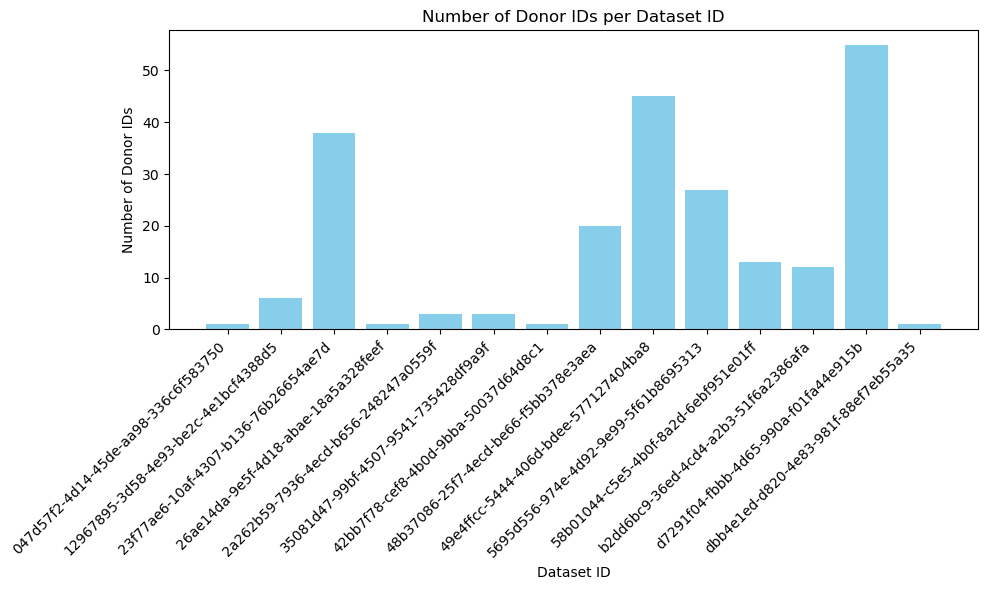

In [3]:
import matplotlib.pyplot as plt
# Calculate the number of donor_ids per dataset_id
dataset_ids = list(dataset_to_donor_map.keys())
donor_counts = [len(donor_ids) for donor_ids in dataset_to_donor_map.values()]

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(dataset_ids, donor_counts, color='skyblue')
plt.xlabel('Dataset ID')
plt.ylabel('Number of Donor IDs')
plt.title('Number of Donor IDs per Dataset ID')
plt.xticks(rotation=45, ha="right")  # Rotate dataset_id labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

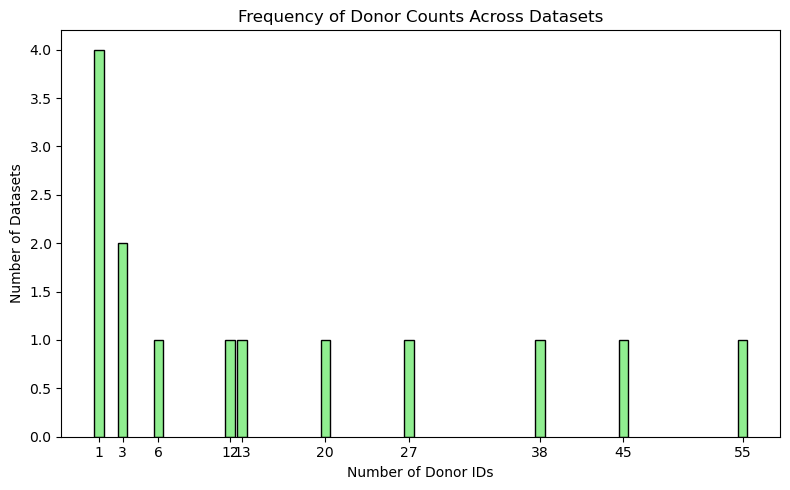

In [4]:
from collections import Counter
# Step 1: Count donor IDs for each dataset
donor_counts = [len(donor_ids) for donor_ids in dataset_to_donor_map.values()]

# Step 2: Create a frequency distribution of donor counts
count_frequencies = Counter(donor_counts)

# Step 3: Sort counts and their frequencies for plotting
sorted_counts = sorted(count_frequencies.items())  # [(donor_count, frequency), ...]

# Split into two lists for plotting
counts, frequencies = zip(*sorted_counts)

# Step 4: Plot the histogram
plt.figure(figsize=(8, 5))
plt.bar(counts, frequencies, color='lightgreen', edgecolor='black')
plt.xlabel('Number of Donor IDs')
plt.ylabel('Number of Datasets')
plt.title('Frequency of Donor Counts Across Datasets')
plt.xticks(counts)  # Ensure all donor counts appear on x-axis
plt.tight_layout()

# Show the plot
plt.show()


In [10]:
# this filtering works
filtered_dataset_to_donor_map = {
    key: value
    for key, value in dataset_to_donor_map.items()
    if isinstance(value, list) and len(value) >= 4  # Check it's a list and has enough items
}

print(f"Filtered dictionary has {len(filtered_dataset_to_donor_map)} datasets.")


Filtered dictionary has 8 datasets.


In [21]:
cd ../

/my_data


/opt/conda/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [11]:
ls

E-MTAB-3718-query-results-neutrophil.tsv
E-MTAB-3718-query-results-signal-trasduction.tsv
Slurm-directory/
Tutorial_cellxgene/
VAE/
VAE.py
VAE_complete/
__pycache__/
adata_droplet_muris_with_leiden_clusters.h5ad
census_container.sqsh
census_exploration.ipynb
census_function.py
container_formation.sh*
container_formation.sh.save*
container_wb.sqsh*
container_wb_all_pack.sqsh*
coverage_estimators/
cytobench/
dataset_id_donor_id.json
dataset_id_donor_id_mus_musculus.json
datasets/
download_last_datasets.py
file_python_scoring/
generate_params.py
job_dataset.sh
jobs_array_simple.sh*
prova_dati.ipynb
save_coverage_estimator.py
saving_data.ipynb
score_VAE.py
score_autoencoder_diff_epochs.py
wandb/


In [12]:
# let's aggregate the datasets
# Then I should calculate the first 256 genes with higher variance and filter the dataset
# Call the function with the subset dictionary
aggregated_data = aggregate_across_datasets(filtered_dataset_to_donor_map, organism="Mus musculus")

Aggregating donors for dataset_id '12967895-3d58-4e93-be2c-4e1bcf4388d5' with donors ['GSM4643732', 'GSM4643733', 'GSM4643734', 'GSM4643736', 'GSM4643737', 'GSM4643738']...
All requested donor IDs have already been downloaded for dataset_id '12967895-3d58-4e93-be2c-4e1bcf4388d5'.
All AnnData slices have been saved in directory: datasets
Loaded data for dataset_id '12967895-3d58-4e93-be2c-4e1bcf4388d5' and donor_id 'GSM4643732' from 'datasets/12967895-3d58-4e93-be2c-4e1bcf4388d5/12967895-3d58-4e93-be2c-4e1bcf4388d5_GSM4643732.h5ad'
Loaded data for dataset_id '12967895-3d58-4e93-be2c-4e1bcf4388d5' and donor_id 'GSM4643733' from 'datasets/12967895-3d58-4e93-be2c-4e1bcf4388d5/12967895-3d58-4e93-be2c-4e1bcf4388d5_GSM4643733.h5ad'
Loaded data for dataset_id '12967895-3d58-4e93-be2c-4e1bcf4388d5' and donor_id 'GSM4643734' from 'datasets/12967895-3d58-4e93-be2c-4e1bcf4388d5/12967895-3d58-4e93-be2c-4e1bcf4388d5_GSM4643734.h5ad'
Loaded data for dataset_id '12967895-3d58-4e93-be2c-4e1bcf4388d5' a

: 

In [8]:
aggregated_data.var

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
0,0,ENSMUSG00000021124,Vti1b,1612,6371264,41233630
1,1,ENSMUSG00000039377,Hlx,2278,431858,41101048
2,2,ENSMUSG00000085604,Dhx58os,1594,111966,39428708
3,3,ENSMUSG00000085125,Gm16070,8345,2267622,40059795
4,4,ENSMUSG00000029439,Sfswap,8000,17009476,41233630
...,...,...,...,...,...,...
52432,52432,ENSMUSG00000118623,Gm52968,2894,0,0
52433,52433,ENSMUSG00000118631,Gm53019,1593,5,301796
52434,52434,ENSMUSG00000118645,Gm55062,480,0,0
52435,52435,ENSMUSG00000118646,Gm56820,383,0,0


### Attention
For small dataset (up to 100000 cells) the following implementation works well, however for very large 
datasets see next code cell

In [10]:
import numpy as np
# Compute variance for each gene
gene_variances = np.var(aggregated_data.X.toarray(), axis=0)  # da valutare se è necessario computare utilizzando delle tecniche compatibili con matrici sparse 

# Get indices of the top 256 genes with highest variance
top_gene_indices = np.argsort(-gene_variances)[:256]

# Filter the AnnData object to keep only the top 256 genes
adata_small = aggregated_data[:, top_gene_indices] 

### Sparse Variance Calculation

To compute the variance of a column vector (gene) from a sparse matrix efficiently, you can use the following formula:

$$
\text{Var}(X) = \frac{1}{n} \left( \sum X^2 \right) - \left( \frac{\sum X}{n} \right)^2
$$

Where:
- \( n \) is the number of cells (rows in the matrix).
- \( \sum X^2 \) is the sum of squared values for a column.
- \( \frac{\sum X}{n} \) is the mean of the values in the column.

This approach avoids converting the sparse matrix to a dense format, which is crucial for handling large datasets efficiently.


In [9]:
from scipy.sparse import csr_matrix
import numpy as np

# Assuming aggregated_data.X is a CSR matrix
X_sparse = aggregated_data.X  # CSR matrix

# Number of cells
n_cells = X_sparse.shape[0]

# Compute the mean for each gene
mean_gene = X_sparse.mean(axis=0)  # Mean is computed efficiently in CSR format

# Compute the squared sum for each gene
squared_sum_gene = X_sparse.multiply(X_sparse).sum(axis=0)  # Element-wise square and sum

# Convert results to 1D arrays
mean_gene = np.array(mean_gene).flatten()
squared_sum_gene = np.array(squared_sum_gene).flatten()

# Compute variance for each gene
variance_gene = (squared_sum_gene / n_cells) - (mean_gene ** 2)

# Get indices of the top 256 genes with highest variance
top_gene_indices = np.argsort(-variance_gene)[:256]

# Filter the AnnData object to keep only the top 256 genes
adata_small = aggregated_data[:, top_gene_indices]

In [10]:
adata_small.var

,soma_joinid,feature_id,feature_name,feature_length,nnz,n_measured_obs
23392,23392,ENSMUSG00000000215,Ins2,1312,400810,40945158
24354,24354,ENSMUSG00000035804,Ins1,1062,329923,40059067
22352,22352,ENSMUSG00000000394,Gcg,1494,333621,40718340
23396,23396,ENSMUSG00000017316,Ppy,500,290896,39556522
19920,19920,ENSMUSG00000041681,Iapp,974,326781,39766876
...,...,...,...,...,...,...
9646,9646,ENSMUSG00000071553,Cpa2,3212,641613,41090582
395,395,ENSMUSG00000040564,Apoc1,744,732713,41226619
19201,19201,ENSMUSG00000029380,Cxcl1,1875,366234,40944665
10461,10461,ENSMUSG00000059654,Reg1,904,72412,39936883


In [13]:
# what is not done is the division of the donor id across the datasets.... 
from collections import defaultdict
import random

def proportional_split_donor_ids(filtered_dataset_to_donor_map, train_ratio=0.6, val_ratio=0.2, test_ratio=0.2):
    # Initialize split containers
    train_split = defaultdict(list)
    val_split = defaultdict(list)
    test_split = defaultdict(list)
    
    for dataset_id, donor_ids in filtered_dataset_to_donor_map.items():
        n_donors = len(donor_ids)
        # Calculate split sizes for this dataset
        n_train = int(n_donors * train_ratio)
        n_val = int(n_donors * val_ratio)
        n_test = n_donors - n_train - n_val  # Ensure all donors are used

        # Shuffle donor IDs for randomness
        shuffled_donors = donor_ids.copy()
        random.shuffle(shuffled_donors)

        # Assign donors to splits
        train_split[dataset_id].extend(shuffled_donors[:n_train])
        val_split[dataset_id].extend(shuffled_donors[n_train:n_train + n_val])
        test_split[dataset_id].extend(shuffled_donors[n_train + n_val:])

    return {"train": train_split, "val": val_split, "test": test_split}

splits = proportional_split_donor_ids(filtered_dataset_to_donor_map)

# Check the results
print("Train:", dict(splits["train"]))
print("Validation:", dict(splits["val"]))
print("Test:", dict(splits["test"]))
# it is also needed to add a column 'categories' with the following key: train val test


Train: 7
Validation: {'12967895-3d58-4e93-be2c-4e1bcf4388d5': ['GSM4643737'], '23f77ae6-10af-4307-b136-76b26654ae7d': ['pooled_aRGC2', 'pooled_aRGC1', 'pooled_MouseACS8', 'pooled_MouseACS10', 'pooled_CTRLC57AllOther2', 'pooled_MouseACS7', 'pooled_10x_retina0315CD73NDRv2'], '48b37086-25f7-4ecd-be66-f5bb378e3aea': ['30-M-2', '1-M-63', '3-M-8', '18-F-50'], '49e4ffcc-5444-406d-bdee-577127404ba8': ['mouse_pancreatic_islet_atlas_Hrovatin__STZ__G6', 'mouse_pancreatic_islet_atlas_Hrovatin__STZ__G2', 'mouse_pancreatic_islet_atlas_Hrovatin__spikein_drug__SRR10751513', 'mouse_pancreatic_islet_atlas_Hrovatin__spikein_drug__SRR10751514', 'mouse_pancreatic_islet_atlas_Hrovatin__STZ__G3', 'mouse_pancreatic_islet_atlas_Hrovatin__STZ__G1', 'mouse_pancreatic_islet_atlas_Hrovatin__NOD_elimination__SRR7610299', 'mouse_pancreatic_islet_atlas_Hrovatin__NOD__SRR10985099', 'mouse_pancreatic_islet_atlas_Hrovatin__NOD__SRR10985098'], '5695d556-974e-4d92-9e99-5f61b8695313': ['170724_O', '170830_AGPM', '170823_AG

In [14]:
# it is also needed to add a column 'categories' with the following key: train val test
import pandas as pd

def add_category_column(aggregated_data, splits):
    # Initialize the 'categories' column with empty strings
    aggregated_data.obs['categories'] = ""

    # Iterate through splits and assign categories
    for category, split_map in splits.items():  # 'train', 'val', 'test'
        for dataset_id, donor_ids in split_map.items():
            # Identify rows in aggregated_data belonging to this dataset_id and donor_id
            matching_rows = aggregated_data.obs[
                (aggregated_data.obs['dataset_id'] == dataset_id) & 
                (aggregated_data.obs['donor_id'].isin(donor_ids))
            ]
            # Assign the category
            aggregated_data.obs.loc[matching_rows.index, 'categories'] = category

    return aggregated_data

# Add the 'categories' column
aggregated_data = add_category_column(aggregated_data, splits)

# Verify the updated column
aggregated_data.obs.tail()


,soma_joinid,dataset_id,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,tissue_ontology_term_id,tissue_type,tissue_general,tissue_general_ontology_term_id,raw_sum,nnz,raw_mean_nnz,raw_variance_nnz,n_measured_vars,categories
1211-Shi-20-18mo-6,2337682,b2dd6bc9-36ed-4cd4-a2b3-51f6a2386afa,10x 3' v2,EFO:0009899,skin fibroblast,CL:0002620,18 month-old stage,MmusDv:0000089,normal,PATO:0000461,...,UBERON:0002097,tissue,skin of body,UBERON:0002097,8314.0,2610,3.185441,131.806917,30089,train
1212-Shi-20-18mo-6,2337683,b2dd6bc9-36ed-4cd4-a2b3-51f6a2386afa,10x 3' v2,EFO:0009899,skin fibroblast,CL:0002620,18 month-old stage,MmusDv:0000089,normal,PATO:0000461,...,UBERON:0002097,tissue,skin of body,UBERON:0002097,6545.0,1919,3.410631,299.534110,30089,train
1213-Shi-20-18mo-6,2337684,b2dd6bc9-36ed-4cd4-a2b3-51f6a2386afa,10x 3' v2,EFO:0009899,skin fibroblast,CL:0002620,18 month-old stage,MmusDv:0000089,normal,PATO:0000461,...,UBERON:0002097,tissue,skin of body,UBERON:0002097,7628.0,2568,2.970405,182.658259,30089,train
1214-Shi-20-18mo-6,2337685,b2dd6bc9-36ed-4cd4-a2b3-51f6a2386afa,10x 3' v2,EFO:0009899,skin fibroblast,CL:0002620,18 month-old stage,MmusDv:0000089,normal,PATO:0000461,...,UBERON:0002097,tissue,skin of body,UBERON:0002097,5025.0,2040,2.463235,63.511154,30089,train
1215-Shi-20-18mo-6,2337686,b2dd6bc9-36ed-4cd4-a2b3-51f6a2386afa,10x 3' v2,EFO:0009899,skin fibroblast,CL:0002620,18 month-old stage,MmusDv:0000089,normal,PATO:0000461,...,UBERON:0002097,tissue,skin of body,UBERON:0002097,6686.0,1903,3.513400,266.843012,30089,train


In [22]:
# Count the number of cells in each category
category_counts = aggregated_data.obs['categories'].value_counts()/  aggregated_data.obs.shape[0] * 100

# Print the counts
print(category_counts)

categories
train    52.083457
val      24.246579
test     23.669964
Name: count, dtype: float64


In [23]:
# direi neanche così male, mi aspettavo una divisione peggiore, top !! 

In [ ]:
# saving the filtered dictonary for future use 
import json

# Save to a JSON file
with open("filtered_dataset_id_donor_id_mus_musculus.json", "w") as json_file:
    json.dump(filtered_dataset_to_donor_map, json_file, indent=4)  # indent for pretty formatting

## **Function for saving the aggregate dataset:**
- Once the aggregate dataset has been updated with the train test val division it must be saved to be employed to train the VAE archtecture 
- To limit the training time the number of genes has been reduced to the first 256 genes ordered by descending variance

In [24]:
import os
from anndata import AnnData
# there is no check for existent dataset purposly, because you should save all organically or you can encounter 
# issues with the genes present in the different datasets
def save_anndata_sliced_h5ad(adata: AnnData, output_dir: str):
    """
    Save an AnnData object in slices organized by dataset_id and donor_id as .h5ad files.
    
    Args:
        adata (AnnData): The input AnnData object with `dataset_id` and `donor_id` in `adata.obs`.
        output_dir (str): The directory to save the sliced data.
        
    Returns:
        None
    """
    # Check if required columns are in the AnnData object
    if 'dataset_id' not in adata.obs or 'donor_id' not in adata.obs:
        raise ValueError("The AnnData object must have 'dataset_id' and 'donor_id' in `adata.obs`.")
    
    # Create the output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Group the data by dataset_id
    for dataset_id in adata.obs['dataset_id'].unique():
        # Create a subfolder for the dataset_id
        dataset_dir = os.path.join(output_dir, dataset_id)
        os.makedirs(dataset_dir, exist_ok=True)
        
        # Filter the data for the current dataset_id
        dataset_data = adata[adata.obs['dataset_id'] == dataset_id]
        
        # Group by donor_id within the dataset_id
        for donor_id in dataset_data.obs['donor_id'].unique():
            # Filter the data for the current donor_id
            donor_data = dataset_data[dataset_data.obs['donor_id'] == donor_id]
            
            # File name: dataset_id_donor_id.h5ad
            file_name = f"{dataset_id}_{donor_id}.h5ad"
            file_path = os.path.join(dataset_dir, file_name)
            
            # Save the data as .h5ad
            donor_data.write_h5ad(file_path)
            
            print(f"Saved: {file_path}")


In [ ]:
# Output directory
output_dir = "./VAE_complete/dataset_small"
# Save the AnnData slices as .h5ad files
save_anndata_slices_h5ad(adata_small, output_dir)